# Variational Autoencoder: _MNIST_ and TensorFlow2

using fully-connected/dense layers.

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER = PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, Flatten, BatchNormalization, LeakyReLU, Reshape
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.datasets import mnist
import tensorflow.keras.backend as K
import tensorflow as tf

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import plotly
import plotly.express as px
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

C:\Users\arjun\anaconda3\envs\tensorflow-gpu\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.8.0


In [4]:
# Check GPU availibility-
gpu_devices = tf.config.list_physical_devices('GPU')

if gpu_devices:
    # Get number of available GPUs-
    num_gpus = len(tf.config.list_physical_devices('GPU'))
    print(f"number of GPUs available = {num_gpus}")
    
    print(f"GPU: {gpu_devices}")
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    print(f"GPU details: {details.get('device_name', 'Unknown GPU')}")
else:
    print("No GPU found")

number of GPUs available = 1
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details: NVIDIA GeForce RTX 3080 Laptop GPU


### MNIST data pre-processing

In [5]:
# input image dimensions
img_rows, img_cols = 28, 28

# Load MNIST dataset-
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [6]:
if tf.keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

print(f"input_shape to be used: {input_shape}")

input_shape to be used: (28, 28, 1)


In [7]:
# Specify hyper-parameters-
batch_size = 256
num_classes = 10
num_epochs = 50

In [8]:
# Convert datasets to floating point types-
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [9]:
# By default the image data consists of integers between 0 and 255 for each pixel channel. Neural networks
# work best when each input is inside the range –1 to 1, so we need to divide by 255.

# Normalize the training and testing datasets-
X_train /= 255.0
X_test /= 255.0

In [ ]:
# Convert class vectors/target to binary class matrices or one-hot encoded values-
# y_train = tf.keras.utils.to_categorical(y_train, num_classes)
# y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [10]:
# Reshape training and testing sets-
X_train = X_train.reshape(X_train.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)

In [11]:
print("\nDimensions of training and testing sets are:")
print(f"X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")


Dimensions of training and testing sets are:
X_train.shape: (60000, 784), y_train.shape: (60000,)
X_test.shape: (10000, 784), y_test.shape: (10000,)


In [12]:
# Create TF datasets-
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(60000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(X_test).shuffle(10000).batch(batch_size)

# Needed by 'tf.GradientTape()' API for custom training and testing code.

In [13]:
# Sanity check for min and max values-
min_val = 4
max_val = 0

for x in train_dataset:
    if x.numpy().min() < min_val:
        min_val = x.numpy().min()
    if x.numpy().max() > max_val:
        max_val = x.numpy().max()

In [14]:
min_val, max_val

(0.0, 1.0)

In [15]:
min_val = 4
max_val = 0

for x in test_dataset:
    if x.numpy().min() < min_val:
        min_val = x.numpy().min()
    if x.numpy().max() > max_val:
        max_val = x.numpy().max()

In [16]:
min_val, max_val

(0.0, 1.0)

In [17]:
del min_val, max_val

### Define _VAE_ architecture

In [25]:
class Encoder(Model):
    def __init__(self, latent_space = 3):
        super(Encoder, self).__init__()
            
        self.latent_space = latent_space
        
        self.dense = Dense(
            units = 300, activation = None
        )
        self.bn1 = BatchNormalization()
        self.dense2 = Dense(
            units = 120, activation = None
        )
        self.bn2 = BatchNormalization()
        self.dense3 = Dense(
            units = 50, activation = None
        )
        self.bn3 = BatchNormalization()
        self.encoder_output = Dense(
            units = self.latent_space, activation = None
        )
        self.bn4 = BatchNormalization()
    
    
    def call(self, x):
        x = tf.nn.relu(self.bn1(self.dense(x)))
        x = tf.nn.relu(self.bn2(self.dense2(x)))
        x = tf.nn.relu(self.bn3(self.dense3(x)))
        x = tf.nn.relu(self.bn4(self.encoder_output(x)))
        return x
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = tf.nn.relu(self.bn1(self.dense(x)))
        print(f"dense1 output shape: {x.shape}")
        x = tf.nn.relu(self.bn2(self.dense2(x)))
        print(f"dense2 output shape: {x.shape}")
        x = tf.nn.relu(self.bn3(self.dense3(x)))
        print(f"dense3 output shape: {x.shape}")
        x = tf.nn.relu(self.bn4(self.encoder_output(x)))
        print(f"Encoder output shape: {x.shape}")
        del x
        return None
    

In [14]:
class Decoder(Model):
    def __init__(self, latent_space = 3):
        super(Decoder, self).__init__()
            
        self.latent_space = latent_space
        
        self.dense = Dense(units = self.latent_space, activation = None)
        self.bn1 = BatchNormalization()
        self.dense2 = Dense(units = 50, activation = None)
        self.bn2 = BatchNormalization()
        self.dense3 = Dense(units = 120, activation = None)
        self.bn3 = BatchNormalization()
        self.dense4 = Dense(units = 300, activation = None)
        self.bn4 = BatchNormalization()
        self.decoder_output = Dense(units = 784, activation = None)
    
    
    def call(self, x):
        x = tf.nn.relu(self.bn1(self.dense(x)))
        x = tf.nn.relu(self.bn2(self.dense2(x)))
        x = tf.nn.relu(self.bn3(self.dense3(x)))
        x = tf.nn.relu(self.bn4(self.dense4(x)))
        x = self.decoder_output(x)
        return x
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = tf.nn.relu(self.bn1(self.dense(x)))
        print(f"dense1 output shape: {x.shape}")
        x = tf.nn.relu(self.bn2(self.dense2(x)))
        print(f"dense2 output shape: {x.shape}")
        x = tf.nn.relu(self.bn3(self.dense3(x)))
        print(f"dense3 output shape: {x.shape}")
        x = tf.nn.relu(self.bn4(self.dense4(x)))
        print(f"dense4 output shape: {x.shape}")
        x = self.decoder_output(x)
        print(f"Decoder output shape: {x.shape}")
        del x
        return None
    

In [26]:
class VAE(Model):
    def __init__(self, latent_space = 3):
        super(VAE, self).__init__()
        
        self.latent_space = latent_space
        
        self.encoder = Encoder(latent_space = self.latent_space)
        self.decoder = Decoder(latent_space = self.latent_space)
        
        # Define fully-connected layers for computing mean & log variance-
        self.mu = Dense(units = self.latent_space, activation = None)
        self.log_var = Dense(units = self.latent_space, activation = None)


    def reparameterize(self, mu, logvar):
        # Sample from a multivariate Gaussian distribution.
        # Adds stochasticity or variation-
        eps = tf.random.normal(
            shape = mu.shape, mean = 0.0,
            stddev = 1.0
        )
        return (eps * tf.exp(logvar * 0.5)) + mu
        
    
    def call(self, x):
        x = self.encoder(x)
        mu = self.mu(x)
        log_var = self.log_var(x)
        z = self.reparameterize(mu, log_var)
        x = tf.nn.sigmoid(self.decoder(z))
        
        return x, mu, log_var
    

In [16]:
latent_dim = 3

In [27]:
# Initialize an instance of VAE architecture-
model = VAE(latent_space = latent_dim) 

In [18]:
# Sanity check-
x = next(iter(train_dataset))

In [28]:
pred, mu, log_var = model(x)

In [29]:
pred.shape, x.shape

(TensorShape([256, 784]), TensorShape([256, 784]))

In [30]:
mu.shape, log_var.shape

(TensorShape([256, 3]), TensorShape([256, 3]))

In [31]:
del x, pred, mu, log_var

In [32]:
model.summary()

Model: "vae_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_2 (Encoder)         multiple                  279715    
                                                                 
 decoder_2 (Decoder)         multiple                  280508    
                                                                 
 dense_31 (Dense)            multiple                  12        
                                                                 
 dense_32 (Dense)            multiple                  12        
                                                                 
Total params: 560,247
Trainable params: 558,355
Non-trainable params: 1,892
_________________________________________________________________


In [ ]:
# Save randomly initialize weights-
# model.save_weights("VAE_LeNet300_MNIST_random_weights.h5", overwrite = True)

In [33]:
# Define an optimizer-
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)

In [34]:
def compute_total_loss(data, data_recon, mu, log_var, alpha = 1, beta = 1):
    
    # Compute KL-divergence loss:
    
    # Sum over latent dimensions-
    kl_loss = -0.5 * tf.math.reduce_sum(
        input_tensor = (1 + log_var - tf.square(mu) - tf.exp(log_var)),
        axis = 1
    )
    # Omitting 'axis' will give bad results as it will sum over everything!
    # First, sum over the latent dimensions and then average over the batches.
    
    # kl_loss.shape
    # TensorShape([64])
    
    batchsize = len(kl_loss)
    
    # Compute average KL-divergence over batch size-
    kl_loss = tf.math.reduce_mean(input_tensor = kl_loss)
    
    
    # Compute Reconstruction loss:
    
    # Sum over all pixels-
    '''
    1. Reshape recon_loss so that it is batchsize and a 1-D vector. So, instead
    of having a (multi-dim) tensor, it is now a 2-D matrix/table.
    
    2. Then, sum over the pixels. This is equivalent to summing over the latent
    dimensions for 'kl_div' above. We are summing first the squared error over the
    channels/pixels and then average over the batch dimensions below.
    '''
    recon_loss = tf.square(tf.reshape(tensor = data, shape = (batchsize, -1)) - tf.reshape(tensor = data_recon, shape = (batchsize, -1)))
    
    # recon_loss.shape
    # TensorShape([64, 784])
    
    recon_loss = tf.math.reduce_sum(recon_loss, axis = 1)
    
    # recon_loss.shape
    # TensorShape([64, 784])
    
    recon_loss = tf.math.reduce_mean(recon_loss)
    
    final_loss = (alpha * recon_loss) + (beta * kl_loss)
    
    return final_loss, recon_loss, kl_loss
    

In [35]:
@tf.function
def train_one_step(model, optimizer, data, alpha, beta):
    # Function to perform one step/iteration of training

    with tf.GradientTape() as tape:
        # Make predictions using defined model-
        data_recon, mu, log_var = model(data)
 
        # Compute loss-
        total_loss, recon_loss, kl_loss = compute_total_loss(
            data = data, data_recon = data_recon,
            mu = mu, log_var = log_var,
            alpha = alpha, beta = beta
        )

    # Compute gradients wrt defined loss and weights and biases-
    grads = tape.gradient(total_loss, model.trainable_variables)
    
    # type(grads)
    # list
    
    # Apply computed gradients to model's weights and biases-
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    return total_loss, recon_loss, kl_loss


In [36]:
@tf.function
def test_step(model, optimizer, data, alpha, beta):
    '''
    Function to test model performance
    on testing dataset
    '''
    # Make predictions using defined model-
    data_recon, mu, log_var = model(data)
    
    # Compute loss-
    total_loss, recon_loss, kl_loss = compute_total_loss(
            data = data, data_recon = data_recon,
            mu = mu, log_var = log_var,
            alpha = alpha, beta = beta
        )
    
    return total_loss, recon_loss, kl_loss


In [37]:
print(f"Train VAE model for {num_epochs} epochs")

Train VAE model for 50 epochs


In [38]:
# Python3 dict to contain training metrics-
training_metrics = {}

In [39]:
# Specify hyper-parameter for reconstruction loss vs. kl-divergence
# trade-off-
alpha = 1
beta = 1

In [40]:
# Initialize parameters for Early Stopping manual implementation-
best_val_loss = 10000

In [41]:
for epoch in range(1, num_epochs + 1):
    
    # Epoch train & validation losses-
    train_loss = 0.0
    val_loss = 0.0
    train_recon_loss = 0.0
    val_recon_loss = 0.0
    train_kl_loss = 0.0
    val_kl_loss = 0.0
    
    for data in train_dataset:
        total_train_loss, recon_train_loss, kl_train_loss = train_one_step(
            model = model, optimizer = optimizer,
            data = data, alpha = alpha,
            beta = beta
        )
        
        train_loss += total_train_loss.numpy()
        train_recon_loss += recon_train_loss.numpy()
        train_kl_loss += kl_train_loss.numpy()
        
    
    for test_data in test_dataset:
        total_val_loss, recon_val_loss, kl_val_loss = test_step(
            model = model, optimizer = optimizer,
            data = test_data, alpha = alpha,
            beta = beta
        )
        
        val_loss += total_val_loss.numpy()
        val_recon_loss += recon_val_loss.numpy()
        val_kl_loss += kl_val_loss.numpy()

    training_metrics[epoch] = {
        'total_loss': train_loss, 'recon_loss': train_recon_loss,
        'kl_loss': train_kl_loss, 'total_val_loss': val_loss,
        'recon_val_loss': val_recon_loss, 'val_kl_loss': val_kl_loss
        }
    

    print(f"epoch = {epoch}; total train loss = {train_loss:.4f},"
    f" train recon loss = {train_recon_loss:.4f}, train kl loss = {train_kl_loss:.4f};"
    f" total val loss = {val_loss:.4f}, val recon loss = {val_recon_loss:.4f} &"
    f" val kl loss = {val_kl_loss:.4f}"
    )
    
    
    # Save 'best' model so far-
    if val_loss < best_val_loss:
        # Update for lowest val_loss so far-
        best_val_loss = val_loss
        
        print(f"\nSaving model with lowest Total validation loss = {val_loss:.4f}\n")
        
        # Save trained model with 'best' validation loss-
        model.save_weights("VAE_MNIST_LeNet300_best_total_val_loss.h5", overwrite = True)


epoch = 1; total train loss = 23266.1171, train recon loss = 21798.2403, train kl loss = 1467.8768; total val loss = 2212.9130, val recon loss = 2159.5788 & val kl loss = 53.3342

Saving model with lowest Total validation loss = 2212.9130

epoch = 2; total train loss = 12478.1885, train recon loss = 12299.4501, train kl loss = 178.7384; total val loss = 2098.3232, val recon loss = 2072.5511 & val kl loss = 25.7721

Saving model with lowest Total validation loss = 2098.3232

epoch = 3; total train loss = 12274.4462, train recon loss = 12111.6625, train kl loss = 162.7837; total val loss = 2084.5919, val recon loss = 2055.1212 & val kl loss = 29.4708

Saving model with lowest Total validation loss = 2084.5919

epoch = 4; total train loss = 12156.1897, train recon loss = 11950.4094, train kl loss = 205.7803; total val loss = 2059.3391, val recon loss = 2020.8764 & val kl loss = 38.4627

Saving model with lowest Total validation loss = 2059.3391

epoch = 5; total train loss = 12030.1588, t

In [ ]:
# Save trained model-
# model.save_weights("VAE_MNIST_LeNet300_last_epoch.h5", overwrite = True)

In [42]:
# Save training metrics-
with open("VAE_MNIST_LeNet300_training_metrics.pkl", "wb") as file:
    pickle.dump(training_metrics, file)

### Visualizations

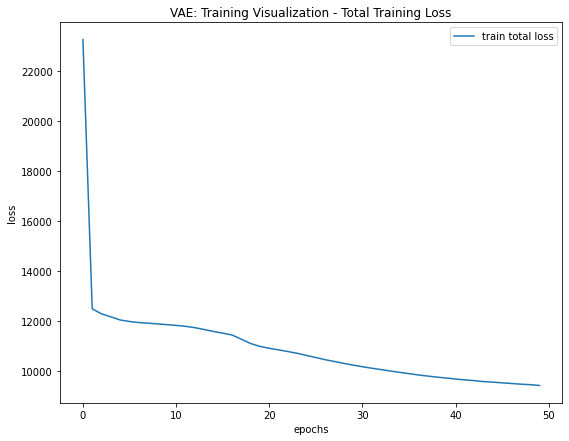

In [43]:
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['total_loss'] for e in training_metrics.keys()], label = 'train total loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("VAE: Training Visualization - Total Training Loss")
plt.show()

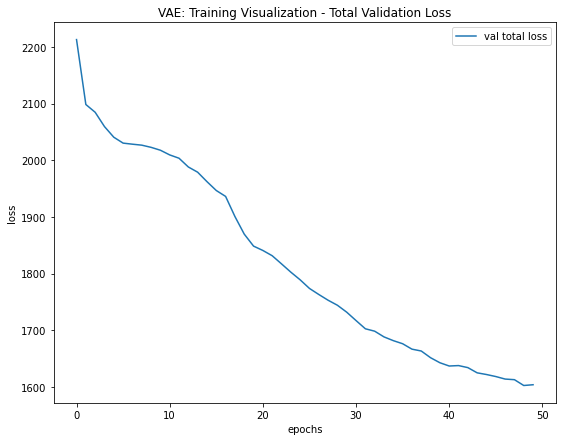

In [44]:
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['total_val_loss'] for e in training_metrics.keys()], label = 'val total loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("VAE: Training Visualization - Total Validation Loss")
plt.show()

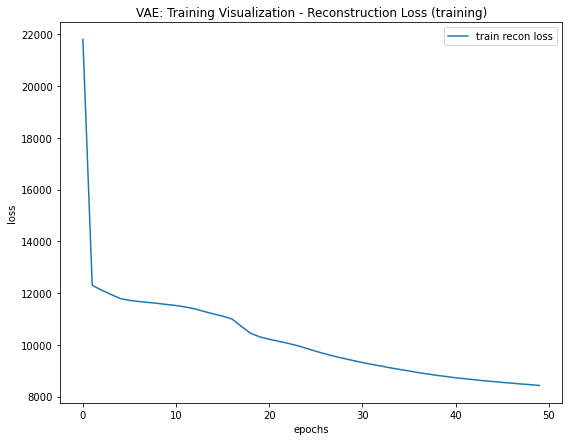

In [45]:
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['recon_loss'] for e in training_metrics.keys()], label = 'train recon loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("VAE: Training Visualization - Reconstruction Loss (training)")
plt.show()

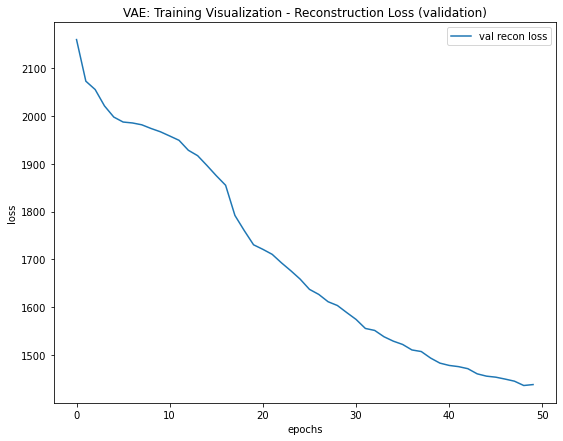

In [46]:
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['recon_val_loss'] for e in training_metrics.keys()], label = 'val recon loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("VAE: Training Visualization - Reconstruction Loss (validation)")
plt.show()

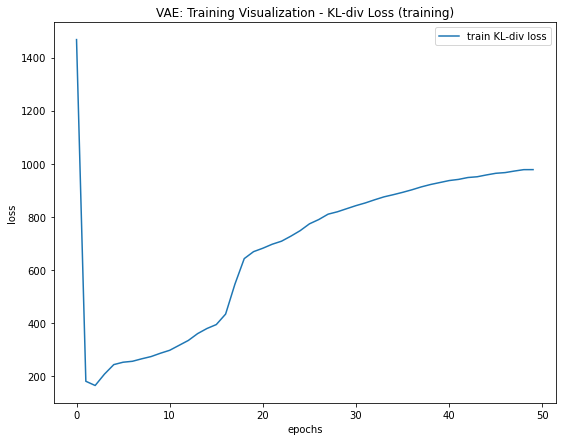

In [47]:
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['kl_loss'] for e in training_metrics.keys()], label = 'train KL-div loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("VAE: Training Visualization - KL-div Loss (training)")
plt.show()

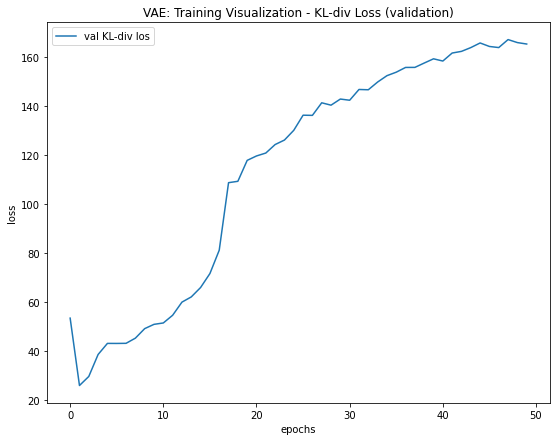

In [48]:
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['val_kl_loss'] for e in training_metrics.keys()], label = 'val KL-div los')
plt.legend(loc = 'best')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title("VAE: Training Visualization - KL-div Loss (validation)")
plt.show()

In [49]:
trained_model = VAE(latent_space = latent_dim)

In [50]:
x = next(iter(train_dataset))

In [51]:
pred, mu, log_var = trained_model(x)

In [52]:
del x, pred, mu, log_var

In [53]:
trained_model.load_weights("VAE_MNIST_LeNet300_best_total_val_loss.h5")

In [54]:
# Python3 list to contain new synthesized images-
synthesis = []

In [ ]:
# Python3 lists to contain mean and log-var vectors-
# mu_l = []
# logvar_l = []

In [ ]:
'''
# Reconstruct new images using given image (cheating)-
for x_t in test_dataset:
    pred, mu, log_var = model(x_t)
    synthesis.append(pred)
    mu_l.append(mu)
    logvar_l.append(log_var)
'''

In [55]:

# Synthesize new images by sampling from standard, normal distribution-
for _ in test_dataset:
    z = tf.random.normal(
        shape = (batch_size, latent_dim), mean = 0.0,
        stddev = 1.0
    )
    pred = tf.nn.sigmoid(model.decoder(z))
    synthesis.append(pred)


In [56]:
synthesis = np.vstack(synthesis)
# mu_l = np.vstack(mu_l)
# logvar_l = np.vstack(logvar_l)

In [57]:
del pred, mu, log_var

In [57]:
synthesis = synthesis.reshape(-1, 28, 28)

In [58]:
synthesis.shape

(10240, 28, 28)

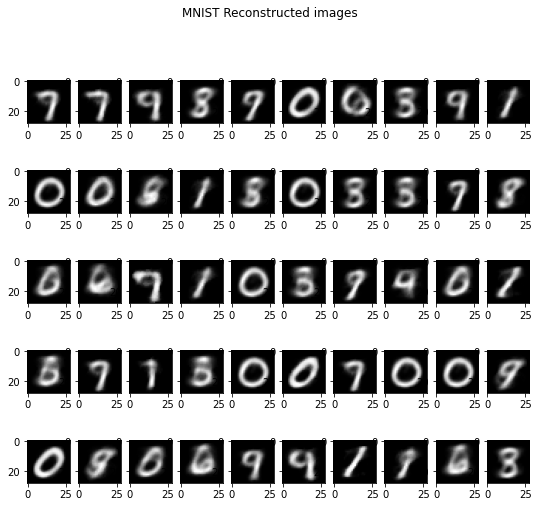

In [59]:
# Visualize some of the reconstruced images-
plt.figure(figsize = (9, 8))
for i in range(50):
    # 5 rows & 10 columns-
    plt.subplot(5, 10, i + 1)
    plt.imshow(synthesis[i], cmap = plt.get_cmap('gray'))
    
plt.suptitle("MNIST Reconstructed images")
plt.show()

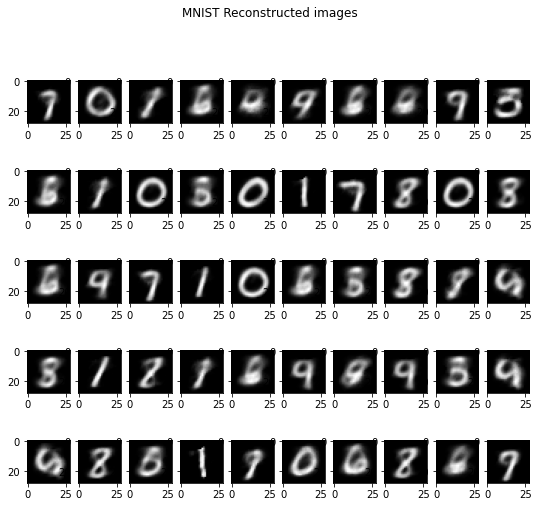

In [61]:
# Visualize some of the reconstruced images-
plt.figure(figsize = (9, 8))
for i in range(50):
    # 5 rows & 10 columns-
    plt.subplot(5, 10, i + 1)
    plt.imshow(synthesis[i + 100], cmap = plt.get_cmap('gray'))
    
plt.suptitle("MNIST Reconstructed images")
plt.show()

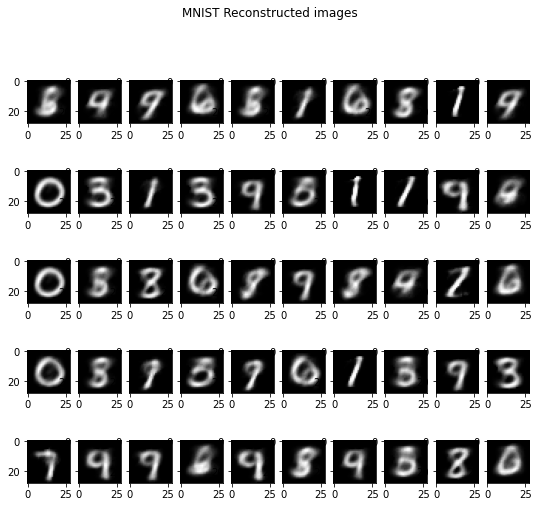

In [62]:
# Visualize some of the reconstruced images-
plt.figure(figsize = (9, 8))
for i in range(50):
    # 5 rows & 10 columns-
    plt.subplot(5, 10, i + 1)
    plt.imshow(synthesis[i + 6000], cmap = plt.get_cmap('gray'))
    
plt.suptitle("MNIST Reconstructed images")
plt.show()